In [102]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier as mlp 
import os
import numpy as np
import time
torch.autograd.set_detect_anomaly(True)

In [103]:
# training
BATCH_SIZE = 100
if(os.path.isdir(os.path.join(os.getcwd(), '../data/MNIST'))):
    trainset = datasets.MNIST('../data/', train=True, download=False,
                   transform=transforms.ToTensor())
else:
    trainset = datasets.MNIST('../data/', train=True, download=True,
                   transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print("Done !")

0it [00:00, ?it/s]

100%|█████████▉| 170483712/170498071 [13:02<00:00, 223824.27it/s]

Done !


170500096it [13:20, 223824.27it/s]                               

In [32]:
class DeepCluster(nn.Module):
    
    def __init__(self, K, D, layers = [400,15]):
        super(DeepCluster, self).__init__()
        
        self.K = K
        self.idim = D # Assuming input to be N x D dimensional matrix
        self.layer_sizes = layers
        self.W = len(self.layer_sizes)
        self.fc_first = nn.Linear(self.idim, layers[0], 'relu')
        self.fc1 = nn.Linear(layers[0], layers[1], 'relu')
        self.fc_last = nn.Linear(self.layer_sizes[-1], self.K, 'linear')
    
        with torch.no_grad():
            self.C = None
            self.K_lr = 0.1
            self.loss = nn.CrossEntropyLoss()
        
    
    def forward(self, input):
        
        x = input.view(-1, self.idim)
        x = self.fc_first(x)
        x = self.fc1(x)
        g = x[:,:]
        x = self.fc_last(x)
    
        return x, g

    def get_counts(self, labels):
        bins = [0]*self.K
        
        for l in list(labels.detach().numpy()):
            bins[l] += 1
        
        return bins
        
    def cluster_feats(self, feats, update = True):
        
        with torch.no_grad():
            N ,K = feats.shape
            ### Implementation of Kmeans clustering
            if(self.C is None):
                self.C = feats[:self.K,:].view(self.K, K)

            # Finding nearest assigments..
            x_lazy = feats.view(N, 1, K)
            c_lazy = self.C.view(1, self.K, K)
            D = ((x_lazy - c_lazy)**2).sum(-1)
            labels = D.argmin(dim=1).view(-1)
            
            
            
            Nc = self.get_counts(labels)
#             print(Nc)
            c = self.C[:,:]
            for k in range(self.K):
                if(Nc[k] == 0):
                    c[k,:] = c[k-1,:]+torch.rand_like(feats[k,:]*10e-4)
                else:
                    pass
                
            # Finding nearest assigments..
            c_lazy = c.view(1, self.K, K)
            D = ((x_lazy - c_lazy)**2).sum(-1)
            labels = D.argmin(dim=1).view(-1)
            
            Nc = self.get_counts(labels)
#             print(Nc)
            for k in range(self.K):
                if(Nc[k] == 0):
                    pass
                else:
                    vec = feats[labels == k].view(-1,K)
                    c[k,:] = vec.sum(0)/Nc[k]
            
            if(update):
                self.C = self.K_lr*(c) + (1-self.K_lr)*self.C

            return labels.long()
    
    def get_loss(self, x):
        
        out, feats = self.forward(x)
        with torch.no_grad():
            labels = self.cluster_feats(feats.clone().detach())
        
        loss = self.loss(out, labels)
        return loss

In [83]:
device = 'cpu'
lsize = [400,50]
model = DeepCluster(30, 784, lsize)

In [84]:
opt = torch.optim.Adam(model.parameters(), 0.0001, amsgrad = True)
train_loss = []
times = []

In [86]:
start = time.time()
for epoch in range(500):
    
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
        opt.zero_grad() 
        
        l = model.get_loss(images)
        l.backward()
        opt.step()
    
        train_loss.append(l.detach())
        times.append(time.time() - start)
        
        if(i%10 == 0):
            clr(wait = True)
            print("Epoch no :", epoch + 1, "batch_no :", i, "curr_loss :",  train_loss[-1], ' time_e:', time.time() - start)
        
plt.plot(train_loss)
plt.show()

Epoch no : 428 batch_no : 20 curr_loss : tensor(0.7330)  time_e: 3334.3352675437927


KeyboardInterrupt: 

In [87]:
x, g = model.forward(images)

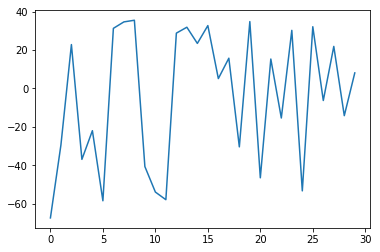

In [88]:
plt.plot(x.detach().numpy()[5])

In [89]:
np.unique(labels, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 97, 132, 105,  84, 117,  81, 102,  99,  92,  91]))

In [90]:
np.unique(model.cluster_feats(g, False), return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([ 6, 45, 59, 25, 33, 23, 24, 24, 45, 30, 20, 19, 13, 12, 33, 20, 58,
        50, 38, 19, 17, 38, 54, 48, 33, 40, 27, 63, 44, 40]))

In [91]:
labels[model.cluster_feats(g, False) == 4]

tensor([5, 8, 7, 0, 4, 0, 5, 6, 4, 4, 2, 0, 4, 0, 0, 5, 2, 8, 0, 7, 4, 2, 2, 5,
        6, 0, 0, 4, 0, 7, 0, 5, 8])

In [92]:
labels[labels == 9]

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [100]:
features = []
ys = []
for i, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
        x, g = model.forward(images)
        features.append(g.detach().numpy())
        ys.append(labels.detach().numpy())        

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f2c516a3d08>
Traceback (most recent call last):
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/abhi/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f2c516a3d08>
Traceback (most recent call last):
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/abhi/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/abhi/a

In [94]:
cfier = mlp(hidden_layer_sizes=(10)) 

In [95]:
Y  = np.array(ys).reshape(-1,1)

In [96]:
X = np.array(features).reshape(-1,50)

In [97]:
X.shape, Y.shape

((60000, 50), (60000, 1))

In [98]:
cfier.fit(X[:50000],Y[:50000])

/home/abhi/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abhi/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [99]:
cfier.score(X[50000:],Y[50000:])

0.7301